In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
from Bio import SeqIO
from model import CouplingsModel
from datetime import datetime

In [2]:
### 1. sample from MCMC with a markov process
###     Underlying distribution: AA only depends on previous position. Probability bigram matrix of alphabets based on war_and_peace.txt
### 2. Create a2m files from the samples
### 3. Train a potts model with plmc
### 4. Observe dependency matrices
np.random.seed(0)
ALPHABET_PROTEIN = 'ACDEFGHIKLMNPQRSTVWY'

In [3]:
from collections import OrderedDict
def encode(seqs, alphabet=ALPHABET_PROTEIN):
    '''
    Go from letters to numbers
    '''
    aa_to_i = OrderedDict((aa, i) for i, aa in enumerate( alphabet ))
    X = np.asarray([[aa_to_i[x] for x in seq] 
                    for seq in seqs])
    return X, aa_to_i
def one_hot_encode(s):
    return np.eye(21)[s].flatten()

In [4]:
### first learn the conditional probabilities
input_file = "war_and_peace.txt"

def build_bigram_freq_matrix(input_file):
    """
    Builds a matrix that represents the transitional
    probabilities between letters in input_file.
    
    bigram_freq_matrix[0][1] is the probability of
    transitioning from the 0th letter of the alphabet
    to the 1st letter of the alphabet, where letters
    are zero-indexed. ' ' (space) is denoted as the
    26th letter of the alphabet.
    """
    counts = np.ones([27, 27])
    with open(input_file, 'r', encoding='utf8') as f:
        for _ in range(100000):
            line = f.readline()
            if len(line) > 2:
                for i in range(len(line) - 2):
                    first_char = ord(line[i].upper()) - 65 if line[i].isalpha() else 26
                    second_char = ord(line[i+1].upper()) - 65 if line[i+1].isalpha() else 26
                    if not (first_char == 26 and second_char == 26) and first_char <= 26 and second_char <= 26:
                        counts[first_char][second_char] += 1
        bigram_freq_matrix = (counts.T / np.sum(counts, axis=1)).T
    return bigram_freq_matrix

freq_matrix = build_bigram_freq_matrix(input_file)

### freq_matrix is based on all 26 letters of the english alphabet + space
### map the matrix to protein alphabets
indices = []
for aa in list(ALPHABET_PROTEIN):
    if aa == '-':
        indices.append(26)
    else:
        indices.append(ord(aa)-ord('A'))


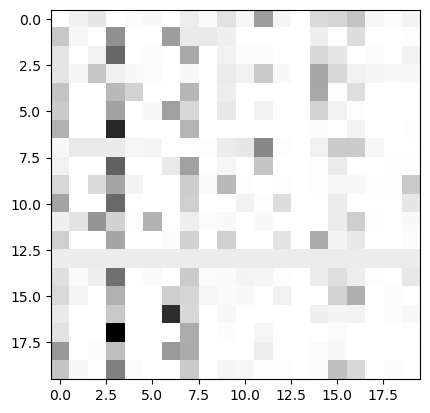

In [5]:
### only take letters in the protein alphabet

protein_freq_matrix = freq_matrix[indices]
protein_freq_matrix = protein_freq_matrix[:, indices]

### normalize it so probabilities sum to 1
for x in protein_freq_matrix:
    x /= np.sum(x)

### check for valid probabilities

assert np.all(protein_freq_matrix >= 0) and np.all(protein_freq_matrix <= 1)
plt.imshow(protein_freq_matrix, cmap='binary', interpolation='none')    

In [6]:
def sample(bigram, length, first_letter):
    seq = first_letter
    cur_letter = first_letter
    while len(seq) < length:
        # iteratively append to the sequence according to bigram frequency
        bigram_freq = bigram[ALPHABET_PROTEIN.index(cur_letter)]
        
        # draw next letter from the given bigram distribution
        next_letter = np.random.choice(list(ALPHABET_PROTEIN), p=bigram_freq)
        seq += next_letter
        cur_letter = next_letter
    return seq

def draw_samples_MP(bigram, length, n):
    samples = []
    for _ in range(n):
        random_first_letter = np.random.choice(list(ALPHABET_PROTEIN))
        samples.append(sample(bigram, length, random_first_letter))
    return samples

def sample_two_letters(bigram, length, first_letter):
    seq = first_letter
    cur_letter = first_letter
    while len(seq) < length:
        # iteratively append to the sequence according to bigram frequency
        bigram_freq = bigram[("AB").index(cur_letter)]
        
        # draw next letter from the given bigram distribution
        next_letter = np.random.choice(list("AB"), p=bigram_freq)
        seq += next_letter
        cur_letter = next_letter
    return seq

def draw_samples_MP_two_letters(bigram, length, n):
    samples = []
    for _ in range(n):
        random_first_letter = np.random.choice(list("AB"))
        samples.append(sample_two_letters(bigram, length, random_first_letter))
    return samples


In [7]:
samples = draw_samples_MP(protein_freq_matrix, 20, 100000)

In [9]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

records = (SeqRecord(Seq(''.join(seq)), str(index)) for index,seq in enumerate(samples) )
with open("simulation/markov.a2m", "w") as output_handle:
    SeqIO.write(records, output_handle, "fasta")

In [10]:
### training code for model
!plmc/bin/plmc -o simulation/markov.model_params -c simulation/markov.txt -f 0 -le 3.8 -lh 0.01 -m 200 -t 0.2 -g simulation/markov.a2m

Found focus 0 as sequence 1
100000 valid sequences out of 100000 
20 sites out of 20
Effective number of samples (to 1 decimal place): 99998.0	(80% identical neighborhood = 1.000 samples)
iter	time	cond	fx	-loglk	||h||	||e||
1	0.2	2693.13	4892182.2	4892081.3	24.3	5.0
2	0.2	3700.57	4338860.9	4334157.5	25.1	35.2
3	0.3	2134.96	4310221.5	4301032.1	24.0	49.2
4	0.3	1189.37	3980571.8	3973994.8	23.9	41.6
5	0.4	1144.06	3906889.4	3902385.6	23.9	34.4
6	0.5	483.32	3852524.3	3847025.7	23.7	38.0
7	0.5	478.65	3812182.6	3805875.1	23.6	40.7
8	0.6	568.55	3697179.1	3687016.7	23.2	51.7
9	0.7	601.62	3668911.4	3657184.7	23.2	55.5
10	0.7	360.55	3633448.7	3620200.6	23.3	59.0
11	0.8	349.47	3605054.5	3589997.9	23.6	62.9
12	0.8	318.45	3586544.4	3570902.9	23.8	64.1
13	0.9	273.64	3565954.4	3549628.9	24.0	65.5
14	0.9	290.10	3536536.7	3518714.9	24.1	68.5
15	1.1	220.60	3523873.8	3504610.0	24.1	71.2
16	1.1	168.42	3514010.1	3494505.4	24.0	71.6
17	1.2	168.79	3498615.7	3478236.6	23.8	73.2
18	1.2	244.39	3487975.4	3466117.

In [11]:
c = CouplingsModel(f"simulation/markov.model_params")

In [12]:
c.J_ij.shape

(20, 20, 20, 20)

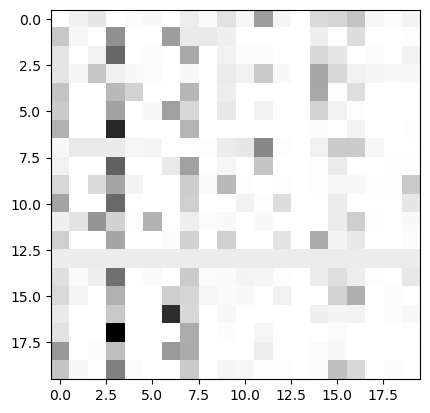

In [13]:
plt.imshow(protein_freq_matrix, cmap='binary', interpolation='none')    

(20, 20)


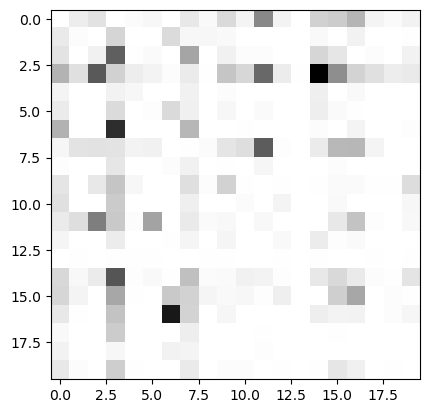

In [14]:
### count empiracally the bigram frequencies

empirical_bigram = np.zeros((20, 20))
print(empirical_bigram.shape)
for s in samples:
    for i in range(len(s) - 1):
        empirical_bigram[ALPHABET_PROTEIN.index(s[i])][ALPHABET_PROTEIN.index(s[i+1])] += 1
plt.imshow(empirical_bigram, cmap='binary', interpolation='none')    

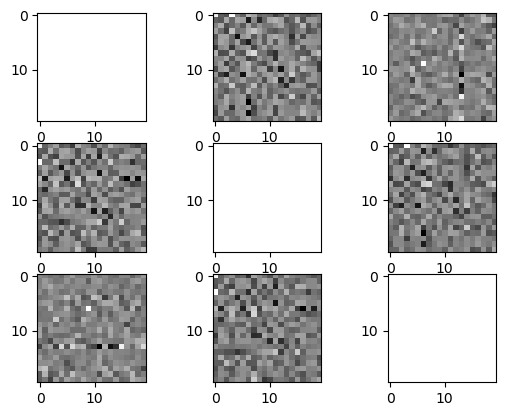

In [15]:
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, 3*i+j+1)
        plt.imshow(c.J_ij[i][j], cmap='binary', interpolation='none')

In [19]:
data = samples
encoded_data, _ = encode(data)
encoded_data = [one_hot_encode(x) for x in encoded_data]

In [20]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(kernel='poly', degree=2, nu=0.3)
train = encoded_data[:70000]
clf.fit(train)

OneClassSVM(degree=2, kernel='poly', nu=0.3)

In [ ]:
def eval(negatives, positives):
    pred = clf.predict(positives)
    
    enc_n, _ = encode(negatives)
    enc_n = [one_hot_encode(x) for x in enc_n]
    pred_n = clf.predict(enc_n)
    correct = np.sum(pred[np.where(pred==1)]) - np.sum(pred_n[np.where(pred_n==-1)])
    print(np.sum(pred_n[np.where(pred_n==-1)]))
    print(np.sum(pred[np.where(pred==1)]))
    return correct/(len(negatives) + len(positives))

In [57]:
negatives = np.random.choice(list(ALPHABET_PROTEIN), size=(10000, 3))
eval(negatives, encoded_data[70000:])

-8840
19662


0.71255

In [58]:
c.seq()

array(['N', 'E', 'R'], dtype='<U1')

In [59]:
# modify energy computation to enable computing sequences with gap characters
def mod_convert_sequences(sequences, c):
    """
    Converts sequences in string format into internal symbol representation
    according to alphabet of model

    Parameters
    ----------
    sequences : list of str
        List of sequences (must have same length and correspond to
        model states)

    Returns
    -------
    np.array
        Matrix of size len(sequences) x L of sequences converted to
        integer symbols
    """
    seq_lens = list(set(map(len, sequences)))
    if len(seq_lens) != 1:
        raise ValueError("Input sequences have different lengths: " + str(seq_lens))

    L_seq = seq_lens[0]

    S = np.empty((len(sequences), L_seq), dtype=int)

    try:
        for i, s in enumerate(sequences):
            conv = []
            for x in s:
                if x == '-':
                    conv.append(-1)
                else:
                    conv.append(c.alphabet_map[x])
            S[i] = conv
    except KeyError:
        raise ValueError("Invalid symbol in sequence {}: {}".format(i, x))
    return S
    
def mod_hamiltonians(sequences, J_ij, h_i):
    """
    Calculates the Hamiltonian of the global probability distribution P(A_1, ..., A_L)
    for a given sequence A_1,...,A_L from J_ij and h_i parameters

    Parameters
    ----------
    sequences : np.array
        Sequence matrix for which Hamiltonians will be computed
    J_ij: np.array
        L x L x num_symbols x num_symbols J_ij pair coupling parameter matrix
    h_i: np.array
        L x num_symbols h_i fields parameter matrix

    Returns
    -------
    np.array
        Float matrix of size len(sequences) x 3, where each row corresponds to the
        1) total Hamiltonian of sequence and the 2) J_ij and 3) h_i sub-sums
    """
    # iterate over sequences
    N, L = sequences.shape
    H = np.zeros((N, 3))
    for s in range(N):
        A = sequences[s]
        hi_sum = 0.0
        Jij_sum = 0.0
        for i in range(L):
            if A[i] != -1:
                hi_sum += h_i[i, A[i]]
                for j in range(i + 1, L):
                    if A[j] != -1:
                        Jij_sum += J_ij[i, j, A[i], A[j]]

        H[s] = [Jij_sum + hi_sum, Jij_sum, hi_sum]

    return H

def energies_from_model(c, sequences):
    S = mod_convert_sequences(sequences.tolist(), c)
    msa_energies = mod_hamiltonians(S, c.J_ij, c.h_i)
    return msa_energies

In [64]:
pos = energies_from_model(c, np.asarray(data[70000:]))[:, 0]
neg = energies_from_model(c, np.asarray(negatives))[:, 0]

In [61]:
x=c.hamiltonians([c.seq()])[0][0]
x

1.2978668361902237

In [66]:
print(pos[np.where(pos >= x)].shape)
print(neg[np.where(neg >= x)].shape)

(13298,)
(2127,)


In [6]:
protein_freq_matrix.shape

(20, 20)

Experiment 5.1: Ensure that SVM works on a somewhat similar problem. The main idea is having two different methods of generating sequences with pre-encoded pairwise frequences, and train a one class SVM on one set of the sequences.

In [41]:
seq_len = 20
np.random.seed(0)
training_seq = draw_samples_MP(protein_freq_matrix, seq_len, 10000)

negative_matrix = protein_freq_matrix[np.random.permutation(protein_freq_matrix.shape[0])]

negatives = draw_samples_MP(negative_matrix, seq_len, 1000)
positives = draw_samples_MP(protein_freq_matrix, seq_len, 1000)

pos_perm = np.random.permutation(seq_len)
neg_perm = np.random.permutation(seq_len)



assert not np.allclose(pos_perm, neg_perm)
assert not np.allclose(negative_matrix, protein_freq_matrix)

In [42]:
training_seq, _ = encode(training_seq)
training_seq = np.asarray([x[pos_perm] for x in training_seq])
mutation = [np.copy(training_seq[0]) for _ in range(1000)]
for i in range(len(mutation)):
    mutation[i][i%training_seq.shape[1]] = training_seq[i][i%training_seq.shape[1]]
training_seq = np.asarray([one_hot_encode(x) for x in training_seq])
mutation = np.asarray([one_hot_encode(x) for x in mutation])

positives, _ = encode(positives)
positives = np.asarray([x[pos_perm] for x in positives])
positives = np.asarray([one_hot_encode(x) for x in positives])


negatives, _ = encode(negatives)
negatives = np.asarray([x[neg_perm] for x in negatives])
negatives = np.asarray([one_hot_encode(x) for x in negatives])

In [43]:
def expand_rich(arr):
    d = arr.shape[1]
    rich = np.zeros((arr.shape[0], d**2))
    for seq in range(arr.shape[0]):
        for i in range(d):
            for j in range(i, d):
                if arr[seq][i] == 1 and arr[seq][j] == 1 or i == j:
                    rich[seq][i*d + j] = 1
    return rich

def expand_rich_no_linear(arr):
    d = arr.shape[1]
    rich = np.zeros((arr.shape[0], d**2))
    for seq in range(arr.shape[0]):
        for i in range(d):
            for j in range(i + 1, d):
                if arr[seq][i] == 1 and arr[seq][j] == 1:
                    rich[seq][i*d + j] = 1
    return rich

In [44]:
rich_training = expand_rich(training_seq)
rich_pos = expand_rich(positives)
rich_neg = expand_rich(negatives)
rich_mutation = expand_rich(mutation)

In [45]:
rich_training.shape

(10000, 176400)

In [46]:
from sklearn.svm import OneClassSVM
for n in [0.000001, 0.000002, 0.00001, 0.00002, 0.0001, 0.0002, 0.999]:
    clf = OneClassSVM(kernel='linear', nu=n)
    clf.fit(rich_training)
    pred_pos = clf.predict(rich_pos)
    pred_neg = clf.predict(rich_neg)

    true_pos = np.count_nonzero(pred_pos == 1)
    true_neg = np.count_nonzero(pred_neg != 1)
    result = (true_neg + true_pos)/(pred_neg.shape[0] + pred_pos.shape[0])
    print(f'kernel: linear, nu: {n}, result: ', result)
    print("true pos: ", true_pos)
    print("true neg: ", true_neg)

In [ ]:
assert not np.allclose(rich_mutation[0], rich_mutation[1])

In [ ]:
pred_t = clf.predict(rich_mutation)

In [13]:
from sklearn.svm import OneClassSVM
for n in [0.001, 0.002, 0.01, 0.02, 0.1, 0.2, 0.25, 0.3]:
    clf = OneClassSVM(kernel='rbf', nu=n)
    clf.fit(rich_training[:30000])
    pred_pos = clf.predict(rich_pos)
    pred_neg = clf.predict(rich_neg)

    true_pos = np.count_nonzero(pred_pos == 1)
    true_neg = np.count_nonzero(pred_neg != 1)
    result = (true_neg + true_pos)/(pred_neg.shape[0] + pred_pos.shape[0])
    print(f'kernel: rbf, nu: {n}, result: ', result)
    print("true pos: ", true_pos)
    print("true neg: ", true_neg)

kernel: rbf, nu: 0.001, result:  0.736
true pos:  936
true neg:  536
kernel: rbf, nu: 0.002, result:  0.736
true pos:  938
true neg:  534
kernel: rbf, nu: 0.01, result:  0.739
true pos:  941
true neg:  537
kernel: rbf, nu: 0.02, result:  0.732
true pos:  937
true neg:  527
kernel: rbf, nu: 0.1, result:  0.7565
true pos:  882
true neg:  631
kernel: rbf, nu: 0.2, result:  0.7245
true pos:  780
true neg:  669


In [18]:
linear_coef = clf.coef_

In [19]:
linear_coef


array([[1034.60407217,  673.8698665 ,  735.75853433, 1102.14662534,
         663.93964177,  651.13802251,  832.46418281, 1046.82170856,
         575.34590032,  865.01223122,  644.49057642,  933.75463691,
         694.35138002,  306.        ,  871.26304642,  853.64399703,
         783.40181048,  482.72755662,  514.82992714,  734.43628341,
           0.        ,  816.18910716,  714.20733718,  714.2072219 ,
         814.71760153,  758.16302436,  702.83846887,  680.56628748,
         816.18881032,  702.83851875,  798.49050756,  727.75066801,
         822.75844422,  742.92390948,  907.27182563,  746.71718594,
         749.21113178,  702.83853042,  671.6722853 ,  692.78383465,
         717.66529943,    0.        , 1055.56844989,  684.6104313 ,
         755.97244348, 1138.2567273 ,  648.        ,  677.86585997,
         829.6900791 , 1070.74117217,  565.        ,  865.96184237,
         711.        ,  879.94309445,  668.91354747,   78.        ,
         879.94289005,  878.65619126,  839.48628

In [ ]:
from sklearn.svm import OneClassSVM
n = 0.15
clf2 = OneClassSVM(kernel='rbf', nu=n)
clf2.fit(training_seq)
pred_pos = clf2.predict(positives)
pred_neg = clf2.predict(negatives)

true_pos = np.count_nonzero(pred_pos == 1)
true_neg = np.count_nonzero(pred_neg != 1)
result = (true_neg + true_pos)/(pred_neg.shape[0] + pred_pos.shape[0])
print(f'kernel: linear, nu: {n}, result: ', result)
print("true pos: ", true_pos)
print("true neg: ", true_neg)

Hyperparameter Tuning

In [12]:
from sklearn.svm import OneClassSVM

with open('result_simulation.txt', 'a') as file:
    date_time = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    file.write(date_time)
    file.write('\n\n')
    # train a linear model, which should theoretically be similar to the potts model.
    for n in [0.001, 0.002, 0.01, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]:
        clf = OneClassSVM(kernel='linear', nu=n)
        clf.fit(training_seq)
        pred_pos = clf.predict(positives)
        pred_neg = clf.predict(negatives)
        
        true_pos = np.count_nonzero(pred_pos == 1)
        true_neg = np.count_nonzero(pred_neg != 1)
        result = (true_neg + true_pos)/(pred_neg.shape[0] + pred_pos.shape[0])
        print(f'kernel: linear, nu: {n}, result: ', result)
        print("true pos: ", true_pos)
        print("true neg: ", true_neg)
        file.write(f'kernel: linear, nu: {n}, result: {result}\n')
        file.write(f'True Positives: {true_pos}, True Negatives: {true_neg}\n\n\n')

In [ ]:
from sklearn.svm import OneClassSVM

with open('result_simulation.txt', 'a') as file:
    date_time = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    file.write(date_time)
    file.write('\n\n')
    # train a linear model, which should theoretically be similar to the potts model.
    for n in [0.001, 0.002, 0.01, 0.02, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.7, 0.9]:
        clf = OneClassSVM(kernel='rbf', nu=n)
        clf.fit(training_seq)
        pred_pos = clf.predict(positives)
        pred_neg = clf.predict(negatives)
        
        true_pos = np.count_nonzero(pred_pos == 1)
        true_neg = np.count_nonzero(pred_neg != 1)
        result = (true_neg + true_pos)/(pred_neg.shape[0] + pred_pos.shape[0])
        print(f'kernel: rbf, nu: {n}, result: ', result)
        print("true pos: ", true_pos)
        print("true neg: ", true_neg)
        file.write(f'kernel: rbf, nu: {n}, result: {result}\n')
        file.write(f'True Positives: {true_pos}, True Negatives: {true_neg}\n\n\n')

kernel: rbf, nu: 0.001, result:  0.545
true pos:  976
true neg:  114
kernel: rbf, nu: 0.002, result:  0.545
true pos:  976
true neg:  114
kernel: rbf, nu: 0.01, result:  0.547
true pos:  977
true neg:  117
kernel: rbf, nu: 0.02, result:  0.548
true pos:  968
true neg:  128
kernel: rbf, nu: 0.1, result:  0.56
true pos:  898
true neg:  222
kernel: rbf, nu: 0.2, result:  0.567
true pos:  810
true neg:  324
kernel: rbf, nu: 0.25, result:  0.556
true pos:  740
true neg:  372
kernel: rbf, nu: 0.3, result:  0.5565
true pos:  701
true neg:  412
kernel: rbf, nu: 0.4, result:  0.5315
true pos:  586
true neg:  477
kernel: rbf, nu: 0.5, result:  0.525
true pos:  500
true neg:  550
kernel: rbf, nu: 0.7, result:  0.4945
true pos:  303
true neg:  686
kernel: rbf, nu: 0.9, result:  0.486
true pos:  90
true neg:  882


Experiment 5.2: Simplified version of 5.2 with only two letters in the protein alphabet. 

In [18]:
def draw_samples_MP_three_letters(bigram, length, n):
    samples = []
    for _ in range(n):
        random_first_letter = np.random.choice(list("ABC"))
        samples.append(sample_three_letters(bigram, length, random_first_letter))
    return samples

def sample_three_letters(bigram, length, first_letter):
    seq = first_letter
    cur_letter = first_letter
    while len(seq) < length:
        # iteratively append to the sequence according to bigram frequency
        bigram_freq = bigram[("ABC").index(cur_letter)]
        
        # draw next letter from the given bigram distribution
        next_letter = np.random.choice(list("ABC"), p=bigram_freq)
        seq += next_letter
        cur_letter = next_letter
    return seq

In [36]:
seq_len = 80
bigram2 = np.asarray([[0.1, 0.8, 0.1], [0.6, 0.2, 0.2], [0.3, 0.3, 0.4]])
neg_bigram2 = np.asarray([[0.6, 0.3, 0.1], [0.1, 0.2, 0.7], [0.3, 0.5, 0.2]])
np.random.seed(1)
training_seq = draw_samples_MP_three_letters(bigram2, seq_len, 10000)

negatives = draw_samples_MP_three_letters(neg_bigram2, seq_len, 1000)
positives = draw_samples_MP_three_letters(bigram2, seq_len, 1000)


In [37]:
one_hot = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]

training_seq = np.asarray([[one_hot[("ABC").index(y)] for y in x] for x in training_seq])
print(training_seq.shape)
training_seq = training_seq.reshape(training_seq.shape[0], seq_len*3)

positives = np.asarray([[one_hot[("ABC").index(y)] for y in x] for x in positives])
positives = positives.reshape(positives.shape[0], seq_len*3)

negatives = np.asarray([[one_hot[("ABC").index(y)]for y in x] for x in negatives])
negatives = negatives.reshape(negatives.shape[0], seq_len*3)

(10000, 80, 3)


In [38]:
rich_training = expand_rich_no_linear(training_seq)
rich_pos = expand_rich_no_linear(positives)
rich_neg = expand_rich_no_linear(negatives)

In [39]:
from sklearn.svm import OneClassSVM
with open('result_simulation.txt', 'a') as file:
    file.write("Experiment 5.2 linear kernel len = 2")
    date_time = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    file.write(date_time)
    file.write('\n\n')
    # train a linear model, which should theoretically be similar to the potts model.
    for n in [0.00001, 0.00002, 0.0001, 0.0002, 0.001, 0.002, 0.01, 0.02, 0.1]:
        clf = OneClassSVM(kernel='linear', nu=n)
        clf.fit(rich_training)
        pred_pos = clf.predict(rich_pos)
        pred_neg = clf.predict(rich_neg)
        
        true_pos = np.count_nonzero(pred_pos == 1)
        true_neg = np.count_nonzero(pred_neg != 1)
        result = (true_neg + true_pos)/(pred_neg.shape[0] + pred_pos.shape[0])
        print(f'kernel: linear, nu: {n}, result: ', result)
        print("true pos: ", true_pos)
        print("true neg: ", true_neg)
        file.write(f'kernel: linear, nu: {n}, result: {result}\n')
        file.write(f'True Positives: {true_pos}, True Negatives: {true_neg}\n\n\n')

kernel: linear, nu: 1e-05, result:  0.956
true pos:  913
true neg:  999
kernel: linear, nu: 2e-05, result:  0.956
true pos:  913
true neg:  999
kernel: linear, nu: 0.0001, result:  0.956
true pos:  913
true neg:  999
kernel: linear, nu: 0.0002, result:  0.956
true pos:  913
true neg:  999
kernel: linear, nu: 0.001, result:  0.956
true pos:  913
true neg:  999
kernel: linear, nu: 0.002, result:  0.956
true pos:  913
true neg:  999
kernel: linear, nu: 0.01, result:  0.956
true pos:  913
true neg:  999
kernel: linear, nu: 0.02, result:  0.957
true pos:  915
true neg:  999
kernel: linear, nu: 0.1, result:  0.936
true pos:  873
true neg:  999


In [25]:
from sklearn.svm import OneClassSVM
n = 0.7
clf = OneClassSVM(kernel='linear', nu=n)
clf.fit(rich_training)
pred_pos = clf.predict(rich_pos)
pred_neg = clf.predict(rich_neg)

true_pos = np.count_nonzero(pred_pos == 1)
true_neg = np.count_nonzero(pred_neg != 1)
result = (true_neg + true_pos)/(pred_neg.shape[0] + pred_pos.shape[0])
print(f'kernel: linear, nu: {n}, result: ', result)
print("true pos: ", true_pos)
print("true neg: ", true_neg)


kernel: linear, nu: 0.7, result:  0.6635
true pos:  477
true neg:  850


In [23]:
clf.intercept_ += 100

In [24]:
clf.decision_function(rich_pos[:20])

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.19234755e-09,  0.00000000e+00,  1.19234755e-09,  0.00000000e+00,
        1.19234755e-09,  1.19234755e-09,  1.19234755e-09, -2.99400000e+03,
        1.19234755e-09,  0.00000000e+00,  0.00000000e+00,  1.19234755e-09,
       -3.02600000e+03,  1.19234755e-09,  0.00000000e+00,  0.00000000e+00])

In [10]:
coef = clf.coef_
print(coef)

NameError: name 'clf' is not defined

In [87]:
clf.decision_function(rich_pos[:20])

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.68984116e-09,  0.00000000e+00,  1.68984116e-09,  0.00000000e+00,
        1.68984116e-09,  1.68984116e-09,  1.68984116e-09, -3.99400000e+03,
        1.68984116e-09,  0.00000000e+00,  0.00000000e+00,  1.68984116e-09,
       -4.02600000e+03,  1.68984116e-09,  0.00000000e+00,  0.00000000e+00])

In [88]:
clf.predict(rich_pos[:20])

array([-1, -1, -1, -1,  1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1, -1,
        1, -1, -1])

In [80]:
rich_pos[:20]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,

Multiclass SVM with positive data and random negative data